In [1]:
from imports.ExtractContactCases import ExtractContactCases

ex = ExtractContactCases('contact_extraction1')
samples = ex.load()

In [2]:
import pandas as pd
import numpy as np

centroids_ = pd.read_csv('centroids.csv')
centroids_.head()

,centroid-0,centroid-1,label
0,50.034483,153.551724,2
1,54.471910,180.449438,3
2,55.947368,126.750000,4
3,69.600000,153.566667,5
4,69.588889,202.411111,6


In [3]:
cents = centroids_.values[:, :2][:, ::-1]
cents

array([[153.55172414,  50.03448276],
       [180.4494382 ,  54.47191011],
       [126.75      ,  55.94736842],
       [153.56666667,  69.6       ],
       [202.41111111,  69.58888889],
       [104.85714286,  71.85714286],
       [173.04123711,  72.40206186],
       [134.4       ,  73.45555556],
       [190.61832061,  83.54961832],
       [118.56818182,  85.32954545],
       [154.        ,  86.        ],
       [170.94736842,  90.13157895],
       [136.64705882,  91.38823529],
       [219.09333333,  92.90666667],
       [ 89.42696629,  94.30337079],
       [201.71764706,  99.54117647],
       [106.66666667, 101.37333333],
       [154.94594595, 103.10810811],
       [183.75675676, 103.04054054],
       [124.41975309, 103.7654321 ],
       [142.60294118, 108.98529412],
       [166.88461538, 108.48076923],
       [171.36923077, 120.04615385],
       [189.        , 120.29333333],
       [225.        , 118.        ],
       [137.10294118, 120.41176471],
       [155.29310345, 120.29310345],
 

In [4]:
from sklearn.model_selection import train_test_split
from torch_geometric import seed_everything
seed_everything(0)

sample_idx = list(samples.keys())
cases = [str(samples[s_idx]['case']) for s_idx in sample_idx]

train_idx, val_test_idx = train_test_split(sample_idx, test_size=1-0.6, random_state=0) #fixed across extractions

cases = [str(samples[s_idx]['case']) for s_idx in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx,  test_size=0.5, random_state=0) #fixed across extractions

In [5]:
from scipy.spatial.distance import cdist
from imports.TactileDataset import cases_dict, list_of_rotations

X_train = np.zeros((len(train_idx), 53))
y_train = np.zeros((len(train_idx), 2))

for i, sample_idx in enumerate(train_idx):
    pos = np.array(samples[sample_idx]['events'])[:, :2]
    d = cdist(pos, cents)
    event_node_idx = np.argmin(d, axis=-1)
    for node_idx in range(len(cents)):
        events_idx = event_node_idx == node_idx
        X_train[i, node_idx] = sum(events_idx)
    y_train[i] = cases_dict[samples[sample_idx]['case']]

In [6]:
X_val = np.zeros((len(val_idx), 53))
y_val = np.zeros((len(val_idx), 2))

for i, sample_idx in enumerate(val_idx):
    pos = np.array(samples[sample_idx]['events'])[:, :2]
    d = cdist(pos, cents)
    event_node_idx = np.argmin(d, axis=-1)
    for node_idx in range(len(cents)):
        events_idx = event_node_idx == node_idx
        X_val[i, node_idx] = sum(events_idx)
    y_val[i] = cases_dict[samples[sample_idx]['case']]

In [7]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=300, max_depth=3)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [8]:
np.degrees(np.mean(np.abs(reg.predict(X_train) - y_train)))

0.032738284623992524

In [9]:
np.degrees(np.mean(np.abs(reg.predict(X_val) - y_val)))

0.8712706492813038

In [10]:
y_val[:5]

array([[-3.22494794e-02,  1.33581718e-02],
       [-4.40085947e-02,  1.06246146e-01],
       [ 2.46826830e-02, -2.46826830e-02],
       [-2.11251573e-17, -1.15000000e-01],
       [-1.15000000e-01,  1.40834382e-17]])

In [11]:
reg.predict(X_val)[:5]

array([[-0.04112528, -0.01394902],
       [-0.04515317,  0.11426168],
       [ 0.01290818, -0.02871226],
       [ 0.00038571, -0.11486316],
       [-0.13163242,  0.00991047]], dtype=float32)

In [12]:
np.degrees(np.max(np.abs(reg.predict(X_val) - y_val)))

4.793908873520726

In [13]:
np.degrees(np.median(np.abs(reg.predict(X_val) - y_val)))

0.7170014188113919

(array([93., 69., 48., 24., 16.,  5.,  1.,  1.,  0.,  1.]),
 array([0.00784051, 0.48644735, 0.96505418, 1.44366102, 1.92226786,
        2.40087469, 2.87948153, 3.35808836, 3.8366952 , 4.31530204,
        4.79390887]),
 <BarContainer object of 10 artists>)

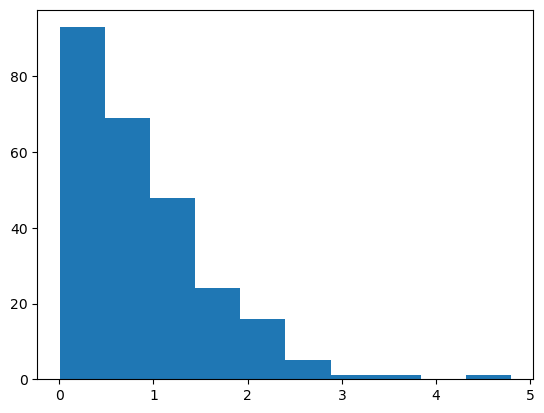

In [14]:
import matplotlib.pyplot as plt

plt.hist(np.degrees(np.abs(reg.predict(X_val) - y_val).ravel()))

In [15]:
sample = samples['sample_101']

In [16]:
angle = 180
ev_arr = np.array(sample['events'])
label = sample['case']

theta = np.radians(angle)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

ev_arr = np.array(ev_arr)
centered = ev_arr[:, :2] - np.array((158, 121))
rot_ev = (R @ centered.T).T + np.array((158, 121))


In [17]:
ev_arr[:5,:]

array([[                153,                  67, 1662379237704126638,
                          0],
       [                168,                 106, 1662379237704213638,
                          0],
       [                189,                 141, 1662379237704393638,
                          0],
       [                151,                  72, 1662379237704459638,
                          1],
       [                114,                  82, 1662379237704464638,
                          0]])

In [18]:
np.concatenate([rot_ev.astype(int), ev_arr[:, 2:]], -1)[:5,:]

array([[                163,                 175, 1662379237704126638,
                          0],
       [                148,                 136, 1662379237704213638,
                          0],
       [                127,                 101, 1662379237704393638,
                          0],
       [                165,                 170, 1662379237704459638,
                          1],
       [                202,                 160, 1662379237704464638,
                          0]])

In [19]:
centered = ev_arr[4,:2] - np.array((158, 121))
(R @ centered.T).T + np.array((158, 121))

array([202., 160.])

In [20]:
cases_dict[label]

[0.028701257427381735, 0.06929096493834651]

In [21]:
import math
rotation_angle=180
rot_mat_ = np.array([ 
    [math.cos(rotation_angle*math.pi/180), math.sin(rotation_angle*math.pi/180)], 
    [-math.sin(rotation_angle*math.pi/180), math.cos(rotation_angle*math.pi/180)] 
])
rot_mat_

array([[-1.0000000e+00,  1.2246468e-16],
       [-1.2246468e-16, -1.0000000e+00]])

In [22]:
R

array([[-1.0000000e+00, -1.2246468e-16],
       [ 1.2246468e-16, -1.0000000e+00]])

In [23]:
rot_v = np.array(cases_dict[label])
new_rot_v = R @ rot_v
#print(new_rot_v, cases_dict[label])

best_rot_diff = 100
best_rot_idx = 1
i = 1

for rot in list_of_rotations:
    diff_vals = np.sqrt( np.power(rot[0] - new_rot_v[0], 2) +  np.power(rot[1] - new_rot_v[1], 2))
    if best_rot_diff > diff_vals:
        best_rot_diff = diff_vals
        best_rot_idx = i
    i = i + 1
    
cases_dict[best_rot_idx]

[-0.028701257427381773, -0.06929096493834648]

In [24]:
imgs = np.zeros((260, 346))
imgs

for x, y in ev_arr[:, :2]:
    imgs[y, x] = 1

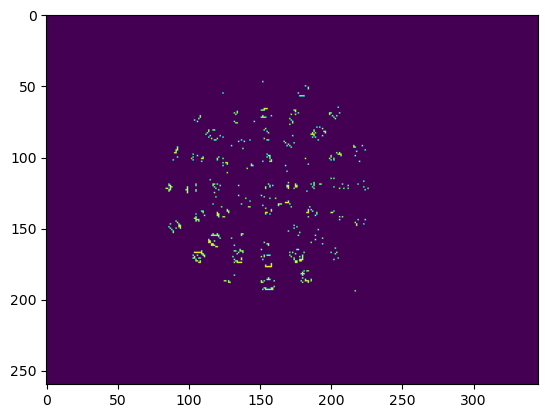

In [25]:
plt.imshow(imgs)

In [26]:
import cv2
rot_mat = cv2.getRotationMatrix2D((158, 121), 180, 1.0)
rotated_image = cv2.warpAffine(imgs, rot_mat, imgs.shape[1::-1], flags=cv2.INTER_LINEAR)


In [27]:
imgs.shape[1::-1]

(346, 260)

In [28]:
121*2

242

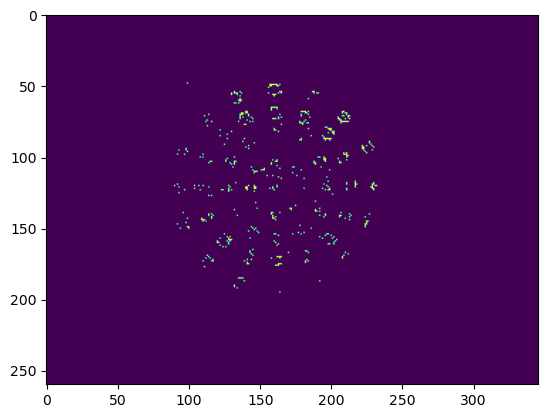

In [29]:
plt.imshow(rotated_image)

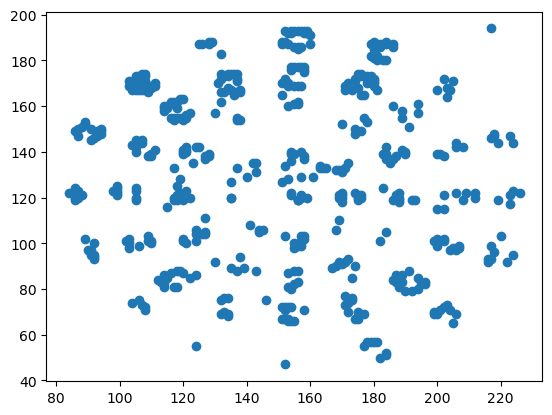

In [30]:
plt.scatter(*ev_arr[:, :2].T)

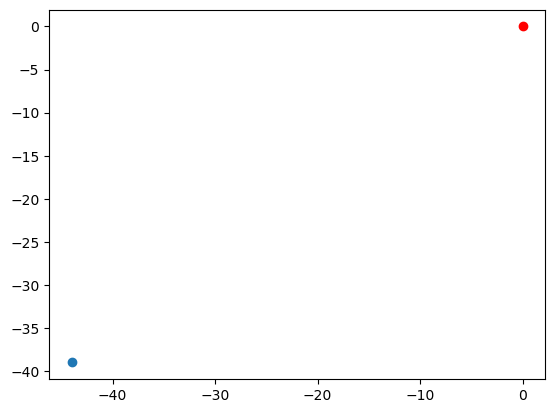

In [31]:
plt.scatter(*centered.T)
plt.scatter(0, 0, c='r')

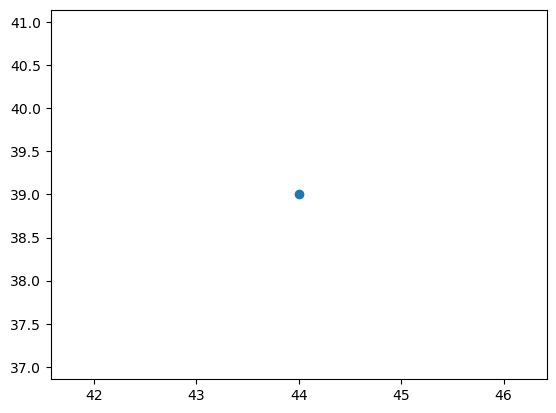

In [32]:
plt.scatter(*(R @ centered.T))

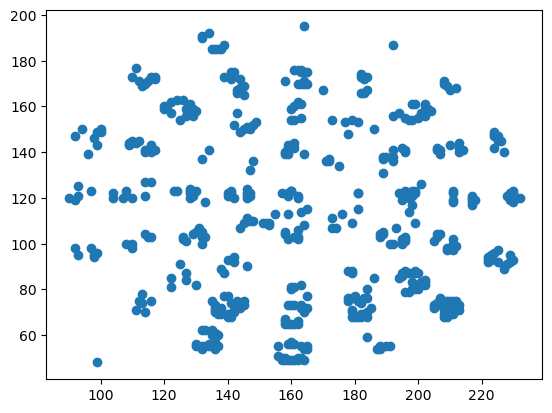

In [33]:
plt.scatter(*rot_ev.T)

In [34]:
rotate_case(sample['events'], sample['case'], 180)

NameError: name 'rotate_case' is not defined

In [ ]:
def aug_gen():
    for i, sample_idx in enumerate(train_idx):
        for angle in [0,180,90,270]:
            if angle == 0:
                yield samples[sample_idx]
            else:
                case, events = rotate_case(samples[sample_idx]['events'], samples[sample_idx]['case'], angle)
                yield {'events': events, 'case': case}

In [ ]:
samples_train = {f'sample_{i+1}': sam for i, sam in enumerate(aug_gen())}

In [ ]:
sample_idx

In [ ]:
X_train_aug = np.zeros((len(samples_train), 53))
y_train_aug = np.zeros((len(samples_train), 2))

for i, sample_idx in enumerate(list(samples_train.keys())):
    pos = np.array(samples_train[sample_idx]['events'])[:, :2]
    d = cdist(pos, cents)
    event_node_idx = np.argmin(d, axis=-1)
    for node_idx in range(len(cents)):
        events_idx = event_node_idx == node_idx
        X_train_aug[i, node_idx] = sum(events_idx)
    y_train_aug[i] = cases_dict[samples_train[sample_idx]['case']]

In [ ]:
reg_aug = xgb.XGBRegressor(n_estimators=300, max_depth=3)
reg_aug.fit(X_train_aug, y_train_aug)

In [ ]:
np.degrees(np.mean(np.abs(reg_aug.predict(X_train_aug) - y_train_aug)))

In [ ]:
np.degrees(np.mean(np.abs(reg_aug.predict(X_val) - y_val)))

In [ ]:
np.degrees(np.max(np.abs(reg_aug.predict(X_val) - y_val)))